In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-24 15:52:53.185557: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8246146568749960742,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 32477282304
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14155889719265973236
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"]

2022-01-24 15:52:53.981801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [2]:
import os
print(os.listdir('./data/flowers'))

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [3]:
# GPU 관련
import os
import tensorflow as tf

In [4]:
# warnings 처리를 위함
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [5]:
# 데이터 시각화를 위함
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [6]:
# model selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_recall_curve, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [7]:
# preprocess
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [8]:
# keras 관련 라이브러리
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random, PIL

In [9]:
# CNN 관련 모듈
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [10]:
batch_size = 32
img_height = 160
img_width = 160

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './data/flowers',
  validation_split = 0.2,
  subset = "training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


2022-01-24 15:52:55.938871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  './data/flowers',
  validation_split = 0.2,
  subset = "validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [13]:
class_names = train_ds.class_names

2022-01-24 15:52:56.761428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


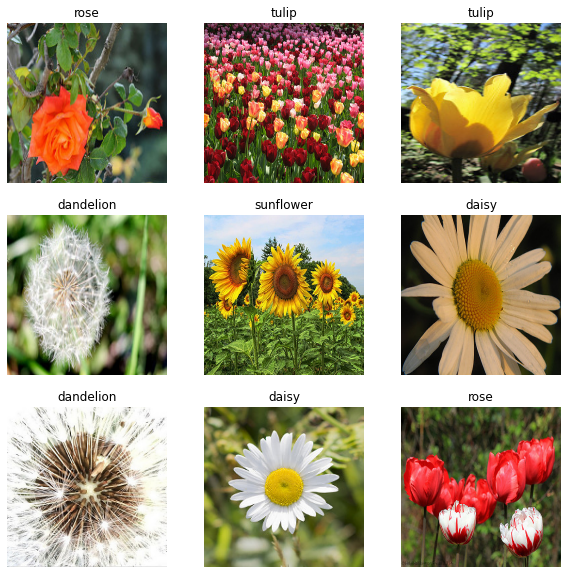

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

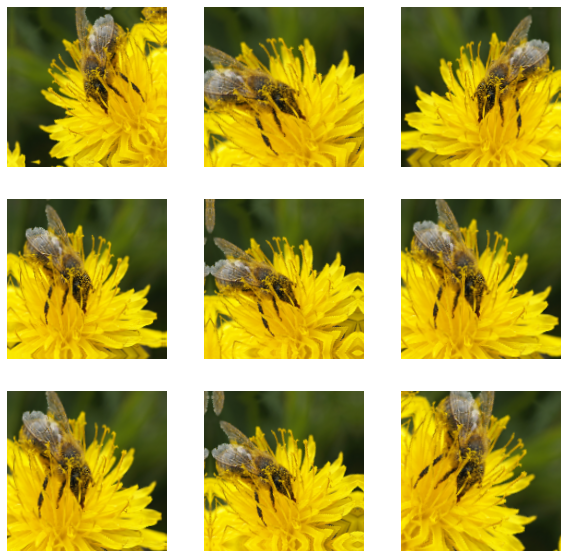

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
num_classes = 5
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='sparse_categorical_crossentropy'),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)       

In [24]:
history = model.fit(
    train_ds, 
    epochs=15,
    validation_data=val_ds
)

Epoch 1/15


2022-01-24 15:53:01.741305: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


108/108 [==============================] - 4s 16ms/step - loss: 1.3893 - accuracy: 0.3940 - val_loss: 1.3870 - val_accuracy: 0.4160
Epoch 2/15
108/108 [==============================] - 1s 12ms/step - loss: 1.0704 - accuracy: 0.5692 - val_loss: 0.9825 - val_accuracy: 0.6222
Epoch 3/15
108/108 [==============================] - 2s 14ms/step - loss: 0.9664 - accuracy: 0.6213 - val_loss: 0.9964 - val_accuracy: 0.5968
Epoch 4/15
108/108 [==============================] - 2s 14ms/step - loss: 0.8973 - accuracy: 0.6500 - val_loss: 0.8899 - val_accuracy: 0.6582
Epoch 5/15
108/108 [==============================] - 1s 13ms/step - loss: 0.8435 - accuracy: 0.6775 - val_loss: 0.8474 - val_accuracy: 0.6721
Epoch 6/15
108/108 [==============================] - 2s 14ms/step - loss: 0.7953 - accuracy: 0.6975 - val_loss: 0.8199 - val_accuracy: 0.6895
Epoch 7/15
108/108 [==============================] - 2s 14ms/step - loss: 0.7577 - accuracy: 0.7079 - val_loss: 0.8290 - val_accuracy: 0.6744
Epoch 8/15

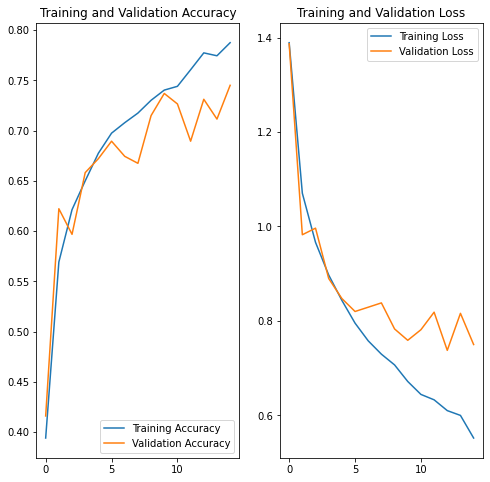

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
test_image_path = './data/test/rose_test.png'
img = tf.keras.utils.load_img(
    test_image_path, grayscale=False, color_mode='rgb', target_size=(img_height, img_width),
    interpolation='nearest'
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진속 꽃은 {} 와 {:.2f} 퍼센트 일치합니다"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

이 사진속 꽃은 rose 와 96.94 퍼센트 일치합니다


### 데이터셋을 바꾸니까 너무 잘된다... ㅠ.ㅠ